In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
data = pd.read_csv('Default_Fin.csv')
data.head()

,Index,Employed,Bank Balance,Annual Salary,Defaulted?
0,1,1,8754.36,532339.56,0
1,2,0,9806.16,145273.56,0
2,3,1,12882.60,381205.68,0
3,4,1,6351.00,428453.88,0
4,5,1,9427.92,461562.00,0


In [3]:
len(data)

10000

## Understanding Data Distribution

In [4]:
print(data.groupby(['Defaulted?', 'Employed'])[['Bank Balance', 'Annual Salary']].describe())
pd.crosstab(data['Employed'], data['Defaulted?'], normalize = 'index').round(2)

                    Bank Balance                                       \
                           count          mean          std       min   
Defaulted? Employed                                                     
0          0              2817.0  11381.762386  5406.643098      0.00   
           1              6850.0   8934.053396  5346.181753      0.00   
1          0               127.0  22324.546772  3944.821339  12158.64   
           1               206.0  20141.152427  3970.966677   7828.80   

                                                            Annual Salary  \
                          25%       50%       75%       max         count   
Defaulted? Employed                                                         
0          0          7684.32  11437.56  15125.88  28658.04        2817.0   
           1          4893.51   8904.78  12734.43  28692.12        6850.0   
1          0         19651.08  22671.96  25323.36  31851.84         127.0   
           1         17768

Defaulted?,0,1
Employed,,
0,0.96,0.04
1,0.97,0.03


3% are defaulters in Employed<br>
4.5% are defaulters in Unemployed

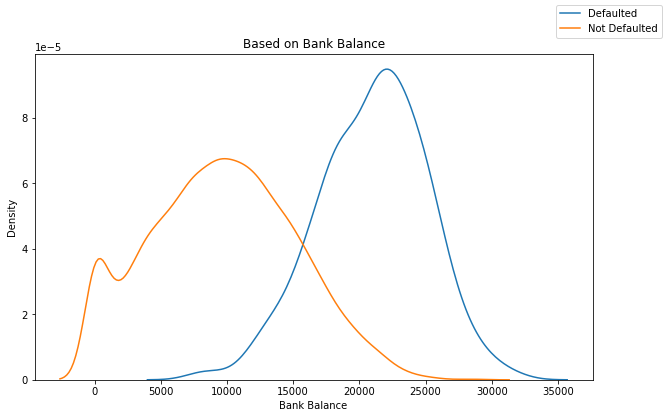

In [5]:
# defaulters vs bank balance distributions
fig = plt.figure(figsize=(10,6))

sns.kdeplot(data[data['Defaulted?']==1]['Bank Balance'])
sns.kdeplot(data[data['Defaulted?']==0]['Bank Balance'])

fig.legend(labels=['Defaulted', 'Not Defaulted'])
plt.title('Based on Bank Balance')
plt.show()

On average, defaulters have higher bank balance than non-defaulters.

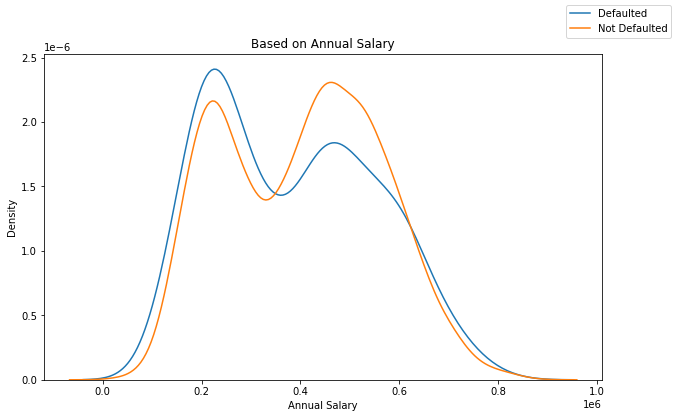

In [6]:
# defaulters vs bank balance distributions
fig = plt.figure(figsize=(10,6))

sns.kdeplot(data[data['Defaulted?']==1]['Annual Salary'])
sns.kdeplot(data[data['Defaulted?']==0]['Annual Salary'])

fig.legend(labels=['Defaulted', 'Not Defaulted'])
plt.title('Based on Annual Salary')
plt.show()

On average, number of defaulters with higher salary are lesser than lower annual salary

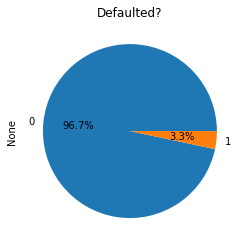

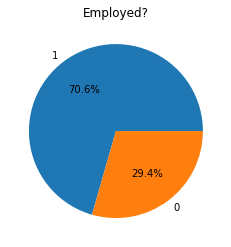

In [7]:
data.groupby('Defaulted?').size().plot.pie(autopct='%1.1f%%', title='Defaulted?');
plt.show()
label=[1,0]
plt.pie(data['Employed'].value_counts(), autopct='%1.1f%%',labels=label);
plt.title('Employed?');

# correlation between features or with target

In [8]:
import scipy.stats as st
print(st.ks_2samp(data['Annual Salary'], data['Bank Balance']))
# based on the pvalue we may say that these two features are highly correlated
# as the number of features are already small we are ignoring it

KstestResult(statistic=0.9997, pvalue=0.0)


# Training Model

In [9]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn import metrics, preprocessing
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC

In [10]:
feature_cols = ['Employed', 'Bank Balance', 'Annual Salary']

''' Rescaling to [0,1] '''
scaler = MinMaxScaler()
data[feature_cols] = scaler.fit_transform(data[feature_cols])

In [11]:
X = data[feature_cols]
y = data['Defaulted?']

validation_size = 0.20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=validation_size, 
                                                    random_state=4, stratify=y)

# Model 1: Logistic Regression

In [12]:
model = LogisticRegression(class_weight='balanced')
model.fit(X_train, y_train)
print(model.coef_)

[[ 0.37752533 13.74108117  0.39631967]]


In [13]:
y_pred = model.predict(X_train)

print('Train metrics...')
print(confusion_matrix(y_train, y_pred))
print(classification_report(y_train, y_pred))

y_pred = model.predict(X_test)

print('Test metrics...')
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Train metrics...
[[6651 1083]
 [  26  240]]
              precision    recall  f1-score   support

           0       1.00      0.86      0.92      7734
           1       0.18      0.90      0.30       266

    accuracy                           0.86      8000
   macro avg       0.59      0.88      0.61      8000
weighted avg       0.97      0.86      0.90      8000

Test metrics...
[[1684  249]
 [   7   60]]
              precision    recall  f1-score   support

           0       1.00      0.87      0.93      1933
           1       0.19      0.90      0.32        67

    accuracy                           0.87      2000
   macro avg       0.60      0.88      0.62      2000
weighted avg       0.97      0.87      0.91      2000



In [14]:
''' metrics on original data '''
y_pred = model.predict(data[feature_cols])

def make_cm(matrix, columns):
    n = len(columns)
    act = ['actual defaulted?'] * n
    pred = ['prediction defaulted ?'] * n

    cm = pd.DataFrame(matrix, 
        columns=[pred, columns], index=[act, columns])
    return cm

df_matrix=make_cm(
    confusion_matrix(data['Defaulted?'], y_pred),['No','Yes'])

display(df_matrix)
print(classification_report(data['Defaulted?'], y_pred))

prediction defaulted ?      
                                          No   Yes
actual defaulted? No                    8335  1332
                  Yes                     33   300

              precision    recall  f1-score   support

           0       1.00      0.86      0.92      9667
           1       0.18      0.90      0.31       333

    accuracy                           0.86     10000
   macro avg       0.59      0.88      0.61     10000
weighted avg       0.97      0.86      0.90     10000



In [15]:
lregprediction = model.predict(X_test)
print("Score: ",model.score(X_test, y_test))

Score:  0.872


In [16]:
import pycalib
from pycalib import metrics
from sklearn.calibration import calibration_curve

In [17]:
y_pred

array([0, 0, 0, ..., 0, 1, 0])

In [18]:
y_test.values

array([0, 0, 0, ..., 0, 0, 0])

In [19]:
scores_lreg = model.predict_proba(X_test)
scores_lreg

array([[0.93885193, 0.06114807],
       [0.95289675, 0.04710325],
       [0.99047119, 0.00952881],
       ...,
       [0.96578879, 0.03421121],
       [0.9965395 , 0.0034605 ],
       [0.77074757, 0.22925243]])

In [20]:
indexes = y_test.index.values
indexes = indexes.tolist()

In [21]:
lregpred = [[] for i in range(len(indexes))]
for i in range(len(indexes)):
    lregpred[i] = (indexes[i], lregprediction[i])
# lregpred

In [22]:
# Calculate the ECE value of lregclassifier
pycalib.metrics.ECE(y_test, lregpred, normalize=False, bins=15, ece_full=True)

0.04525

In [23]:
# brier score
pycalib.metrics.brier_score(y_test.values, lregprediction)

0.128

In [24]:
# cross-entropy (log loss)
pycalib.metrics.cross_entropy(y_test.values, lregprediction)

4.421062928428627

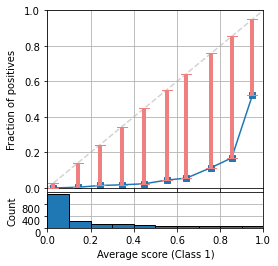

In [25]:
from pycalib.visualisations import plot_reliability_diagram
fig = pycalib.visualisations.plot_reliability_diagram(y_test,
                                                [scores_lreg, ],
                                                legend=None,
                                                show_histogram=True,
                                                bins=10,
                                                class_names=["0","1"],
                                                fig=None,
                                                show_counts=False,
                                                errorbar_interval=None,
                                                interval_method='beta',
                                                fmt='s-',
                                                show_correction=False,
                                                show_gaps=True,
                                                sample_proportion=0,
                                                hist_per_class=False,
                                                color_list=None,
                                                show_bars=False,
                                                invert_histogram=False,
                                                color_gaps='lightcoral',
                                                confidence=False)

# Model 2: SVM

In [26]:
model2 = SVC(class_weight={0: 1, 1: 100}, probability=True)
model2.fit(X_train, y_train)

SVC(class_weight={0: 1, 1: 100}, probability=True)

In [27]:
svmprediction = model2.predict(X_test)
print("Score: ",model2.score(X_test, y_test))

Score:  0.712


In [28]:
y_pred2 = model2.predict(X_train)

print('Train metrics...')
print(confusion_matrix(y_train, y_pred2))
print(classification_report(y_train, y_pred2))

y_pred2 = model.predict(X_test)

print('Test metrics...')
print(confusion_matrix(y_test, y_pred2))
print(classification_report(y_test, y_pred2))

Train metrics...
[[5378 2356]
 [   6  260]]
              precision    recall  f1-score   support

           0       1.00      0.70      0.82      7734
           1       0.10      0.98      0.18       266

    accuracy                           0.70      8000
   macro avg       0.55      0.84      0.50      8000
weighted avg       0.97      0.70      0.80      8000

Test metrics...
[[1684  249]
 [   7   60]]
              precision    recall  f1-score   support

           0       1.00      0.87      0.93      1933
           1       0.19      0.90      0.32        67

    accuracy                           0.87      2000
   macro avg       0.60      0.88      0.62      2000
weighted avg       0.97      0.87      0.91      2000



In [29]:
''' metrics on original data '''
y_pred2 = model2.predict(data[feature_cols])

df_matrix2=make_cm(
    confusion_matrix(data['Defaulted?'], y_pred2),['No','Yes'])

display(df_matrix2)
print(classification_report(data['Defaulted?'], y_pred2))

prediction defaulted ?      
                                          No   Yes
actual defaulted? No                    6736  2931
                  Yes                      7   326

              precision    recall  f1-score   support

           0       1.00      0.70      0.82      9667
           1       0.10      0.98      0.18       333

    accuracy                           0.71     10000
   macro avg       0.55      0.84      0.50     10000
weighted avg       0.97      0.71      0.80     10000



In [30]:
scores_svm = model2.predict_proba(X_test)
scores_svm

array([[9.99757506e-01, 2.42494409e-04],
       [9.99766353e-01, 2.33647248e-04],
       [9.99991481e-01, 8.51873999e-06],
       ...,
       [9.99957143e-01, 4.28572802e-05],
       [9.99999614e-01, 3.86459676e-07],
       [9.86682857e-01, 1.33171433e-02]])

In [31]:
svmpred = [[] for i in range(len(indexes))]
for i in range(len(indexes)):
    svmpred[i] = (indexes[i], svmprediction[i])
# svmpred

In [32]:
pycalib.metrics.ECE(y_test, svmpred, normalize=False, bins=15, ece_full=True)

0.084

In [33]:
svmprediction

array([0, 0, 0, ..., 0, 0, 1])

In [34]:
pycalib.metrics.brier_score(y_test.values, svmprediction)

0.288

In [35]:
pycalib.metrics.cross_entropy(y_test.values, svmprediction)

9.947397485995458

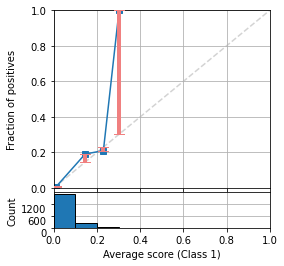

In [36]:
fig = pycalib.visualisations.plot_reliability_diagram(y_test,
                                                [scores_svm, ],
                                                legend=None,
                                                show_histogram=True,
                                                bins=10,
                                                class_names=["0","1"],
                                                fig=None,
                                                show_counts=False,
                                                errorbar_interval=None,
                                                interval_method='beta',
                                                fmt='s-',
                                                show_correction=False,
                                                show_gaps=True,
                                                sample_proportion=0,
                                                hist_per_class=False,
                                                color_list=None,
                                                show_bars=False,
                                                invert_histogram=False,
                                                color_gaps='lightcoral',
                                                confidence=False)

# Reliability Diagram

In [37]:
classifiers = {"Logistic regression": model,
               "SVM": model2}

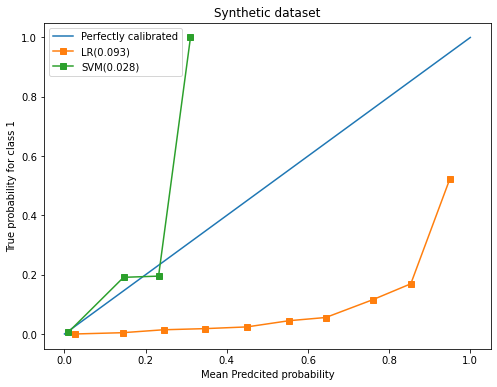

In [38]:
from sklearn.datasets import make_classification as mc
from sklearn.metrics import brier_score_loss # 导入布里尔分数
from sklearn.calibration import calibration_curve # 对概率类模型进行校准，方法是分箱

models = ["LR", "SVM"]
#开始画图
fig,ax1 = plt.subplots(figsize = (8,6))
ax1.plot([0,1],[0,1],label = "Perfectly calibrated") # 绘制对角线，把（0，0），（1，1）连起来
for clf,name_ in zip([model, model2],models):
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    if hasattr(clf,"predict_proba"): #对象里如果有这个接口
        prob_pos = clf.predict_proba(X_test)[:,1]
    else: #就是针对SVM
        prob_pos = clf.decision_function(X_test)
        prob_pos = (prob_pos-prob_pos.min())/(prob_pos.max()-prob_pos.min())  #手动归一化
    clf_score = brier_score_loss(y_test,prob_pos,pos_label=y.max())
    #对只有0，1的标签值进行分箱后才能画图
    trueproba, predproba = calibration_curve(y_test, prob_pos, n_bins=10)
    ax1.plot(predproba,trueproba,"s-",label = "%s(%1.3f)"%(name_,clf_score))
    ax1.set_ylabel("True probability for class 1")
    ax1.set_xlabel("Mean Predcited probability")
    ax1.set_ylim([-0.05,1.05])
    ax1.legend()
plt.title('Synthetic dataset')
plt.savefig('rd2.png')
plt.show()

# Hypothesis Testing

In [39]:
from scipy.stats import percentileofscore
from sklearn.preprocessing import label_binarize
import numpy as np

def label_resampling(probs):
    return np.random.binomial(1, probs)

def score_sampling(probs, samples = 10000, ece_function = None):
    probs = np.array(probs)
    return np.array(
        [
            ece_function(label_resampling(probs), probs) for sample in range(samples)
        ]
    )

def pECE(y_true, probs, samples = 10000, ece_function = pycalib.metrics.binary_ECE):
    probs = np.array(probs)
    return 1 - (
        percentileofscore(
            score_sampling(
                probs,
                samples=samples,
                ece_function=ece_function
            ),
            ece_function(y_true, probs)
        ) / 100
    )

In [40]:
pECE(y_test, scores_lreg[:,1])

0.0

In [41]:
pECE(y_test, scores_svm[:,1])

0.08450000000000002

# Calibration

In [42]:
from __future__ import division
import numpy as np

from scipy.special import expit

from sklearn.base import clone
from sklearn.utils import check_X_y, indexable
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import _SigmoidCalibration
from sklearn.metrics import log_loss

import warnings

from sklearn.base import BaseEstimator, ClassifierMixin, RegressorMixin
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import check_array
from sklearn.utils.validation import check_is_fitted
from inspect import signature
from sklearn.isotonic import IsotonicRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import check_cv


from betacal import BetaCalibration


class _DummyCalibration(BaseEstimator, RegressorMixin):
    """Dummy Calibration model. The purpose of this class is to give
    the CalibratedClassifierCV class the option to just return the
    probabilities of the base classifier.
    """
    def fit(self, *args, **kwargs):
        """Does nothing"""
        return self

    def predict_proba(self, T):
        """Return the probabilities of the base classifier"""
        return T

    def predict(self, scores, *args, **kwargs):
        proba = self.predict_proba(scores, *args, **kwargs)
        return proba.argmax(axis=1)


class IsotonicCalibration(IsotonicRegression):
    def __init__(self):
        super(IsotonicCalibration, self).__init__(y_min=0.0, y_max=1.0,
                                                  increasing=True,
                                                  out_of_bounds='clip')

    def fit(self, scores, y, *args, **kwargs):
        '''
        Score=0 corresponds to y=0, and score=1 to y=1
        Parameters
        ----------
        scores : array-like, shape = [n_samples,]
            Data.
        y : array-like, shape = [n_samples, ]
            Labels.
        Returns
        -------
        self
        '''
        if len(scores.shape) > 1:
            scores = scores[:, 1]
        return super(IsotonicCalibration, self).fit(scores, y, *args, **kwargs)

    def predict_proba(self, scores, *args, **kwargs):
        if len(scores.shape) > 1:
            scores = scores[:, 1]
        transformed = self.transform(scores, *args, **kwargs)
        if len(transformed.shape) == 1:
            transformed = np.vstack((1 - transformed, transformed)).T
        return transformed

    def predict(self, scores, *args, **kwargs):
        proba = self.predict_proba(scores, *args, **kwargs)
        return proba.argmax(axis=1)


def logit(x):
    eps = np.finfo(x.dtype).eps
    x = np.clip(x, eps, 1-eps)
    return np.log(x/(1 - x))


def log_encode(x):
    eps = np.finfo(x.dtype).eps
    x = np.clip(x, eps, 1)
    return np.log(x)


class LogisticCalibration(LogisticRegression):
    def __init__(self, C=1.0, solver='lbfgs', multi_class='multinomial',
                 log_transform=True):
        self.C_grid = C
        self.C = C if isinstance(C, float) else C[0]
        self.solver = solver
        self.log_transform = log_transform
        self.encode = log_encode if log_transform else logit
        self.multiclass = multi_class
        super(LogisticCalibration, self).__init__(C=C, solver=solver,
                                                  multi_class=multi_class)

    def fit(self, scores, y, X_val=None, y_val=None, *args, **kwargs):
        if isinstance(self.C_grid, list):
            calibrators = []
            losses = np.zeros(len(self.C_grid))
            for i, C in enumerate(self.C_grid):
                cal = LogisticCalibration(C=C, solver=self.solver,
                                          multi_class=self.multi_class,
                                          log_transform=self.log_transform)
                cal.fit(scores, y)
                losses[i] = log_loss(y_val, cal.predict_proba(X_val))
                calibrators.append(cal)
            best_idx = losses.argmin()
            self.C = calibrators[best_idx].C
        return super(LogisticCalibration, self).fit(self.encode(scores), y,
                                                    *args, **kwargs)

    def predict_proba(self, scores, *args, **kwargs):
        return super(LogisticCalibration,
                     self).predict_proba(self.encode(scores), *args, **kwargs)

    def predict(self, scores, *args, **kwargs):
        return super(LogisticCalibration, self).predict(self.encode(scores),
                                                        *args, **kwargs)


class SigmoidCalibration(_SigmoidCalibration):
    def fit(self, scores, y, *args, **kwargs):
        if len(scores.shape) > 1:
            scores = scores[:, 1]
        return super(SigmoidCalibration, self).fit(scores, y, *args, **kwargs)

    def predict_proba(self, scores, *args, **kwargs):
        if len(scores.shape) > 1:
            scores = scores[:, 1]
        transformed = super(SigmoidCalibration, self).predict(scores, *args, **kwargs)
        return np.vstack((1 - transformed, transformed)).T

    def predict(self, *args, **kwargs):
        proba = self.predict_proba(*args, **kwargs)
        return proba.argmax(axis=1)


class BinningCalibration(BaseEstimator, RegressorMixin):
    def __init__(self, n_bins=10, strategy='uniform', alpha=1.0):
        '''
        alpha : Laplace smoothing (x + a)/(N + 2a)
        n_bins: Number of bins
        stragegy:
                - uniform: for equal width bins
                - quantile: for equal frequency bins
                - kmeans: for each bin with same nearest center to a 1D k-means
        '''
        self.strategy = strategy
        self.n_bins = n_bins
        self.n_bins_grid = n_bins
        self.alpha = alpha

    def fit(self, scores, y, X_val=None, y_val=None, *args, **kwargs):
        '''
        Score=0 corresponds to y=0, and score=1 to y=1
        Parameters
        ----------
        scores : array-like, shape = [n_samples,]
            Data.
        y : array-like, shape = [n_samples, ]
            Labels.
        Returns
        -------
        self
        '''
        if isinstance(self.n_bins, list):
            if X_val is None or y_val is None:
                raise ValueError(('If n_bins is a list, scores_val and y_val'
                                  'are required during fit'))
            calibrators = []
            losses = []
            for n_bins in self.n_bins:
                cal = BinningCalibration(n_bins=n_bins, strategy=self.strategy,
                                         alpha=self.alpha)
                cal.fit(scores, y)
                predict = cal.predict_proba(X_val)
                losses.append(log_loss(y_val, predict))
                calibrators.append(cal)
            best_idx = np.argmin(losses)
            self.n_bins = calibrators[best_idx].n_bins
            self.bins = calibrators[best_idx].bins
            self.predictions = calibrators[best_idx].predictions
            return self

        if len(np.shape(scores)) > 1:
            scores = scores[:, 1]
        # TODO check that this code is correct:
        if self.strategy == 'quantile':
            self.bins = np.sort(scores)[::int(np.ceil(len(scores)
                                                      / self.n_bins))]
            self.bins = np.hstack([self.bins, scores[-1]])
        elif self.strategy == 'uniform':
            self.bins = np.linspace(scores.min(), scores.max(), self.n_bins+1)
        else:
            raise ValueError('Strategy {} not implemented'.format(
                                 self.strategy))
        self.bins[0] = - np.inf
        self.bins[-1] = np.inf
        s_binned = np.digitize(scores, self.bins) - 1
        self.predictions = np.zeros(self.n_bins)
        for i in range(self.n_bins):
            self.predictions[i] = ((np.sum(y[s_binned == i]) + self.alpha)
                                   / (np.sum(s_binned == i) + self.alpha*2))

        return self

    def predict_proba(self, scores, *args, **kwargs):
        if len(np.shape(scores)) > 1:
            scores = scores[:, 1]
        s_binned = np.digitize(scores, self.bins) - 1
        transformed = self.predictions[s_binned]
        return np.vstack((1 - transformed, transformed)).T

    def predict(self, scores, *args, **kwargs):
        proba = self.predict_proba(scores, *args, **kwargs)
        return proba.argmax(axis=1)


class CalibratedModel(BaseEstimator, ClassifierMixin):
    def __init__(self, base_estimator=None, calibrator=None,
                 fit_estimator=True):
        ''' Initialize a Calibrated model (classifier + calibrator)
        Parameters
        ----------
        base_estimator : estimator
            Classifier instance
        calibrator : estimator
            Calibrator instance
        '''
        self.calibrator = clone(calibrator)
        self.base_estimator = clone(base_estimator)
        self.fit_estimator = fit_estimator
        self.binary = False

    def fit(self, X, y, X_val=None, y_val=None, *args, **kwargs):
        """Fit the calibrated model
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            Training data.
        y : array-like, shape (n_samples, n_classes)
            Target values.
        Returns
        -------
        self : object
            Returns an instance of self.
        """

        X, y = check_X_y(X, y, accept_sparse=['csc', 'csr', 'coo'],
                         multi_output=True)
        X, y = indexable(X, y)

        if self.fit_estimator:
            self.base_estimator.fit(X, y)

        scores = self.base_estimator.predict_proba(X)

        if scores.shape[1] == 2:
            self.binary = True

        if self.binary:
            try:
                self.calibrator.fit(scores, y, *args, **kwargs)
            except ValueError:
                self.calibrator.fit(scores[:, 1], y, *args, **kwargs)
        else:
            self.calibrator.fit(scores, y, *args, **kwargs)

        return self

    def predict_proba(self, X):
        """Posterior probabilities of classification
        This function returns posterior probabilities of classification
        according to each class on an array of test vectors X.
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            The samples.
        Returns
        -------
        C : array, shape (n_samples, n_classes)
            The predicted probas. Can be exact zeros.
        """

        scores = self.base_estimator.predict_proba(X)

        if self.binary:
            try:
                predictions = self.calibrator.predict_proba(scores)
            except ValueError:
                predictions = self.calibrator.predict_proba(scores[:, 1])

            if (len(predictions.shape) == 1) or (predictions.shape[1] == 1):
                predictions = np.vstack((1 - predictions, predictions)).T
        else:
            predictions = self.calibrator.predict_proba(scores)

        return predictions

    def predict(self, X):
        """Predict the target of new samples. Can be different from the
        prediction of the uncalibrated classifier.
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            The samples.
        Returns
        -------
        C : array, shape (n_samples,)
            The predicted class.
        """
        check_is_fitted(self, ["calibrator"])

        return np.argmax(self.predict_proba(X), axis=1)


class CalibratedClassifierCV(BaseEstimator, ClassifierMixin):
    """Probability calibration with isotonic regression, sigmoid or beta.
    With this class, the base_estimator is fit on the train set of the
    cross-validation generator and the test set is used for calibration.
    The probabilities for each of the folds are then averaged
    for prediction. In case cv="prefit" is passed to __init__,
    it is assumed that base_estimator has been
    fitted already and all data is used for calibration. Note that
    data for fitting the classifier and for calibrating it must be disjoint.
    Read more in the :ref:`User Guide <calibration>`.
    Parameters
    ----------
    base_estimator : instance BaseEstimator
        The classifier whose output decision function needs to be calibrated
        to offer more accurate predict_proba outputs. If cv=prefit, the
        classifier must have been fit already on data.
    method : None, 'sigmoid', 'isotonic', 'beta', 'beta_am' or 'beta_ab'
        The method to use for calibration. Can be 'sigmoid' which
        corresponds to Platt's method, 'isotonic' which is a
        non-parameteric approach or 'beta', 'beta_am' or 'beta_ab' which
        correspond to three different beta calibration methods. It is
        not advised to use  isotonic  calibration with too few calibration
        samples ``(<<1000)`` since it tends to overfit.
        Use beta models in this case.
    cv : integer, cross-validation generator, iterable or "prefit", optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
        - None, to use the default 3-fold cross-validation,
        - integer, to specify the number of folds.
        - An object to be used as a cross-validation generator.
        - An iterable yielding train/test splits.
        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If ``y`` is neither binary nor
        multiclass, :class:`KFold` is used.
        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validation strategies that can be used here.
        If "prefit" is passed, it is assumed that base_estimator has been
        fitted already and all data is used for calibration.
    Attributes
    ----------
    classes_ : array, shape (n_classes)
        The class labels.
    calibrated_classifiers_: list (len() equal to cv or 1 if cv == "prefit")
        The list of calibrated classifiers, one for each cross-validation fold,
        which has been fitted on all but the validation fold and calibrated
        on the validation fold.
    References
    ----------
    .. [1] Obtaining calibrated probability estimates from decision trees
           and naive Bayesian classifiers, B. Zadrozny & C. Elkan, ICML 2001
    .. [2] Transforming Classifier Scores into Accurate Multiclass
           Probability Estimates, B. Zadrozny & C. Elkan, (KDD 2002)
    .. [3] Probabilistic Outputs for Support Vector Machines and Comparisons to
           Regularized Likelihood Methods, J. Platt, (1999)
    .. [4] Predicting Good Probabilities with Supervised Learning,
           A. Niculescu-Mizil & R. Caruana, ICML 2005
    """
    def __init__(self, base_estimator=None, method=None, cv=3,
                 score_type=None):
        self.base_estimator = base_estimator
        self.method = method
        self.cv = cv
        self.score_type = score_type

    def fit(self, X, y, sample_weight=None):
        """Fit the calibrated model
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            Training data.
        y : array-like, shape (n_samples,)
            Target values.
        sample_weight : array-like, shape = [n_samples] or None
            Sample weights. If None, then samples are equally weighted.
        Returns
        -------
        self : object
            Returns an instance of self.
        """
        X, y = check_X_y(X, y, accept_sparse=['csc', 'csr', 'coo'],
                         force_all_finite=False)
        X, y = indexable(X, y)
        lb = LabelBinarizer().fit(y)
        self.classes_ = lb.classes_

        # Check that each cross-validation fold can have at least one
        # example per class
        n_folds = self.cv if isinstance(self.cv, int) \
            else self.cv.n_folds if hasattr(self.cv, "n_folds") else None
        if n_folds and \
           np.any([np.sum(y == class_) < n_folds for class_ in self.classes_]):
            raise ValueError("Requesting %d-fold cross-validation but provided"
                             " less than %d examples for at least one class."
                             % (n_folds, n_folds))

        self.calibrated_classifiers_ = []
        if self.base_estimator is None:
            # we want all classifiers that don't expose a random_state
            # to be deterministic (and we don't want to expose this one).
            base_estimator = LinearSVC(random_state=0)
        else:
            base_estimator = self.base_estimator

        if self.cv == "prefit":
            calibrated_classifier = _CalibratedClassifier(
                base_estimator, method=self.method, score_type=self.score_type)
            if sample_weight is not None:
                calibrated_classifier.fit(X, y, sample_weight)
            else:
                calibrated_classifier.fit(X, y)
            self.calibrated_classifiers_.append(calibrated_classifier)
        else:
            cv = check_cv(self.cv, y, classifier=True)
            fit_parameters = signature(base_estimator.fit).parameters
            estimator_name = type(base_estimator).__name__
            if (sample_weight is not None
                    and "sample_weight" not in fit_parameters):
                warnings.warn("%s does not support sample_weight. Samples"
                              " weights are only used for the calibration"
                              " itself." % estimator_name)
                base_estimator_sample_weight = None
            else:
                base_estimator_sample_weight = sample_weight
            for train, test in cv.split(X, y):
                this_estimator = clone(base_estimator)
                if base_estimator_sample_weight is not None:
                    this_estimator.fit(
                        X[train], y[train],
                        sample_weight=base_estimator_sample_weight[train])
                else:
                    this_estimator.fit(X[train], y[train])

                calibrated_classifier = _CalibratedClassifier(
                    this_estimator, method=self.method,
                    score_type=self.score_type)
                if sample_weight is not None:
                    calibrated_classifier.fit(X[test], y[test],
                                              sample_weight[test])
                else:
                    calibrated_classifier.fit(X[test], y[test])
                self.calibrated_classifiers_.append(calibrated_classifier)

        return self

    def predict_proba(self, X):
        """Posterior probabilities of classification
        This function returns posterior probabilities of classification
        according to each class on an array of test vectors X.
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            The samples.
        Returns
        -------
        C : array, shape (n_samples, n_classes)
            The predicted probas.
        """
        check_is_fitted(self, ["classes_", "calibrated_classifiers_"])
        X = check_array(X, accept_sparse=['csc', 'csr', 'coo'],
                        force_all_finite=False)
        # Compute the arithmetic mean of the predictions of the calibrated
        # classfiers
        mean_proba = np.zeros((X.shape[0], len(self.classes_)))
        for calibrated_classifier in self.calibrated_classifiers_:
            proba = calibrated_classifier.predict_proba(X)
            mean_proba += proba

        mean_proba /= len(self.calibrated_classifiers_)

        return mean_proba

    def calibrate_scores(self, df):
        """Posterior probabilities of classification
        This function returns posterior probabilities of classification
        according to each class on an array of test vectors X.
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            The samples.
        Returns
        -------
        C : array, shape (n_samples, n_classes)
            The predicted probas.
        """
        check_is_fitted(self, ["classes_", "calibrated_classifiers_"])
        # Compute the arithmetic mean of the predictions of the calibrated
        # classifiers
        df = df.reshape(-1, 1)
        mean_proba = np.zeros((len(df), len(self.classes_)))
        for calibrated_classifier in self.calibrated_classifiers_:
            proba = calibrated_classifier.calibrate_scores(df)
            mean_proba += proba

        mean_proba /= len(self.calibrated_classifiers_)

        return mean_proba

    def predict(self, X):
        """Predict the target of new samples. Can be different from the
        prediction of the uncalibrated classifier.
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            The samples.
        Returns
        -------
        C : array, shape (n_samples,)
            The predicted class.
        """
        check_is_fitted(self, ["classes_", "calibrated_classifiers_"])
        return self.classes_[np.argmax(self.predict_proba(X), axis=1)]


class _CalibratedClassifier(object):
    """Probability calibration with isotonic regression or sigmoid.
    It assumes that base_estimator has already been fit, and trains the
    calibration on the input set of the fit function. Note that this class
    should not be used as an estimator directly. Use CalibratedClassifierCV
    with cv="prefit" instead.
    Parameters
    ----------
    base_estimator : instance BaseEstimator
        The classifier whose output decision function needs to be calibrated
        to offer more accurate predict_proba outputs. No default value since
        it has to be an already fitted estimator.
    method : 'sigmoid' | 'isotonic' | 'beta' | 'beta_am' | 'beta_ab'
        The method to use for calibration. Can be 'sigmoid' which
        corresponds to Platt's method, 'isotonic' which is a
        non-parameteric approach based on isotonic regression or 'beta',
        'beta_am' or 'beta_ab' which correspond to beta calibration methods.
    References
    ----------
    .. [1] Obtaining calibrated probability estimates from decision trees
           and naive Bayesian classifiers, B. Zadrozny & C. Elkan, ICML 2001
    .. [2] Transforming Classifier Scores into Accurate Multiclass
           Probability Estimates, B. Zadrozny & C. Elkan, (KDD 2002)
    .. [3] Probabilistic Outputs for Support Vector Machines and Comparisons to
           Regularized Likelihood Methods, J. Platt, (1999)
    .. [4] Predicting Good Probabilities with Supervised Learning,
           A. Niculescu-Mizil & R. Caruana, ICML 2005
    """
    def __init__(self, base_estimator, method='beta',
                 score_type=None):
        self.base_estimator = base_estimator
        self.method = method
        self.score_type = score_type

    def _preproc(self, X):
        n_classes = len(self.classes_)
        if self.score_type is None:
            if hasattr(self.base_estimator, "decision_function"):
                df = self.base_estimator.decision_function(X)
                if df.ndim == 1:
                    df = df[:, np.newaxis]
            elif hasattr(self.base_estimator, "predict_proba"):
                df = self.base_estimator.predict_proba(X)
                if n_classes == 2:
                    df = df[:, 1:]
            else:
                raise RuntimeError('classifier has no decision_function or '
                                   'predict_proba method.')
        else:
            if self.score_type == "sigmoid":
                df = self.base_estimator.decision_function(X)
                df = expit(df)
                if df.ndim == 1:
                    df = df[:, np.newaxis]
            else:
                if hasattr(self.base_estimator, self.score_type):
                    df = getattr(self.base_estimator, self.score_type)(X)
                    if self.score_type == "decision_function":
                        if df.ndim == 1:
                            df = df[:, np.newaxis]
                    elif self.score_type == "predict_proba":
                        if n_classes == 2:
                            df = df[:, 1:]
                else:
                    raise RuntimeError('classifier has no ' + self.score_type
                                       + 'method.')

        idx_pos_class = np.arange(df.shape[1])

        return df, idx_pos_class

    def fit(self, X, y, sample_weight=None):
        """Calibrate the fitted model
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            Training data.
        y : array-like, shape (n_samples,)
            Target values.
        sample_weight : array-like, shape = [n_samples] or None
            Sample weights. If None, then samples are equally weighted.
        Returns
        -------
        self : object
            Returns an instance of self.
        """
        lb = LabelBinarizer()
        Y = lb.fit_transform(y)
        self.classes_ = lb.classes_

        df, idx_pos_class = self._preproc(X)
        self.calibrators_ = []

        for k, this_df in zip(idx_pos_class, df.T):
            if self.method is None:
                calibrator = _DummyCalibration()
            elif self.method == 'isotonic':
                calibrator = IsotonicRegression(out_of_bounds='clip')
            elif self.method == 'sigmoid':
                calibrator = _SigmoidCalibration()
            # TODO Remove BetaCalibration
            elif self.method == 'beta':
                calibrator = BetaCalibration(parameters="abm")
            elif self.method == 'beta_am':
                calibrator = BetaCalibration(parameters="am")
            elif self.method == 'beta_ab':
                calibrator = BetaCalibration(parameters="ab")
            else:
                raise ValueError('method should be None, "sigmoid", '
                                 '"isotonic", "beta", "beta2" or "beta05". '
                                 'Got %s.' % self.method)
            calibrator.fit(this_df, Y[:, k], sample_weight)
            self.calibrators_.append(calibrator)

        return self

    def predict_proba(self, X):
        """Posterior probabilities of classification
        This function returns posterior probabilities of classification
        according to each class on an array of test vectors X.
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            The samples.
        Returns
        -------
        C : array, shape (n_samples, n_classes)
            The predicted probas. Can be exact zeros.
        """
        n_classes = len(self.classes_)
        proba = np.zeros((X.shape[0], n_classes))

        df, idx_pos_class = self._preproc(X)
        for k, this_df, calibrator in \
                zip(idx_pos_class, df.T, self.calibrators_):
            if n_classes == 2:
                k += 1
            proba[:, k] = calibrator.predict(this_df)

        # Normalize the probabilities
        if n_classes == 2:
            proba[:, 0] = 1. - proba[:, 1]
        else:
            proba /= np.sum(proba, axis=1)[:, np.newaxis]

        # XXX : for some reason all probas can be 0
        proba[np.isnan(proba)] = 1. / n_classes

        # Deal with cases where the predicted probability minimally exceeds 1.0
        proba[(1.0 < proba) & (proba <= 1.0 + 1e-5)] = 1.0

        return proba

    def calibrate_scores(self, df):
        """Posterior probabilities of classification
        This function returns posterior probabilities of classification
        according to each class on an array of test vectors X.
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            The samples.
        Returns
        -------
        C : array, shape (n_samples, n_classes)
            The predicted probas. Can be exact zeros.
        """
        n_classes = len(self.classes_)
        proba = np.zeros((len(df), n_classes))
        idx_pos_class = [0]

        for k, this_df, calibrator in \
                zip(idx_pos_class, df.T, self.calibrators_):
            if n_classes == 2:
                k += 1
            pro = calibrator.predict(this_df)
            if np.any(np.isnan(pro)):
                pro[np.isnan(pro)] = calibrator.predict(this_df[np.isnan(
                    pro)] + 1e-300)
            proba[:, k] = pro

        # Normalize the probabilities
        if n_classes == 2:
            proba[:, 0] = 1. - proba[:, 1]
        else:
            proba /= np.sum(proba, axis=1)[:, np.newaxis]

        # XXX : for some reason all probas can be 0
        proba[np.isnan(proba)] = 1. / n_classes

        # Deal with cases where the predicted probability minimally exceeds 1.0
        proba[(1.0 < proba) & (proba <= 1.0 + 1e-5)] = 1.0
        return proba

In [43]:
def plot_calibration_curve(y_true, y_prob, n_bins=5, ax=None, hist=True, normalize=False):
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=n_bins, normalize=normalize)
    if ax is None:
        ax = plt.gca()
    if hist:
        ax.hist(y_prob, weights=np.ones_like(y_prob) / len(y_prob), alpha=.4,
               bins=np.maximum(10, n_bins))
    ax.plot([0, 1], [0, 1], ':', c='k')
    curve = ax.plot(prob_pred, prob_true, marker="o")

    ax.set_xlabel("predicted probability")
    ax.set_ylabel("fraction of positive samples")

    ax.set(aspect='equal')
    return curve

## 1. LR

In [44]:
# sigmoid
cal_lr_sigm = CalibratedClassifierCV(model, cv="prefit", method='sigmoid')
cal_lr_sigm.fit(X_test, y_test)
scores_lr_sigm = cal_lr_sigm.predict_proba(X_test)

# Cross-validated Calibration
cal_lr_sigm_cv = CalibratedClassifierCV(model, method='sigmoid')
cal_lr_sigm_cv.fit(X_train, y_train)
scores_lr_sigm_cv = cal_lr_sigm_cv.predict_proba(X_test)

# isotonic
cal_lr_iso = CalibratedClassifierCV(model, cv="prefit", method='isotonic')
cal_lr_iso.fit(X_test, y_test)
scores_lr_iso = cal_lr_iso.predict_proba(X_test)

# Cross-validated Calibration
cal_lr_iso_cv = CalibratedClassifierCV(model, method='isotonic')
cal_lr_iso_cv.fit(X_train, y_train)
scores_lr_iso_cv = cal_lr_iso_cv.predict_proba(X_test)

# beta
cal_lr_beta = CalibratedClassifierCV(model, method='beta')
cal_lr_beta.fit(X_train, y_train)
scores_lr_beta = cal_lr_beta.predict_proba(X_test)

# Cross-validated Calibration
cal_lr_beta_cv = CalibratedClassifierCV(model, cv="prefit", method='beta')
cal_lr_beta_cv.fit(X_test, y_test)
scores_lr_beta_cv = cal_lr_beta_cv.predict_proba(X_test)

/Users/jacinth/miniforge3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/jacinth/miniforge3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/jacinth/miniforge3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/jacinth/miniforge3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


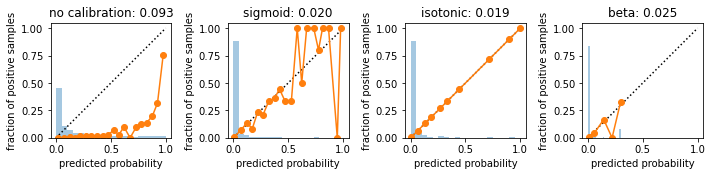

In [45]:
fig, axes = plt.subplots(1, 4, figsize=(10, 4))

for name, s, ax in zip(['no calibration', 'sigmoid', 'isotonic', 'beta'],
                       [scores_lreg[:, 1], scores_lr_sigm[:, 1], scores_lr_iso[:, 1], scores_lr_beta[:, 1]], axes):
    plot_calibration_curve(y_test, s, n_bins=20, ax=ax)
    ax.set_title("{}: {:.3f}".format(name, brier_score_loss(y_test, s)))
plt.tight_layout()

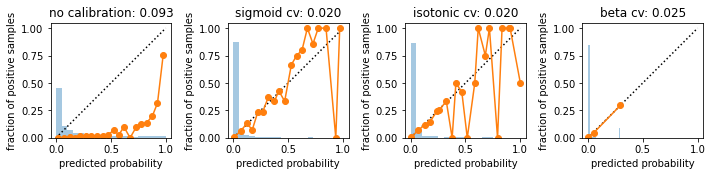

In [46]:
fig, axes = plt.subplots(1, 4, figsize=(10, 4))

for name, s, ax in zip(['no calibration','sigmoid cv', 'isotonic cv','beta cv'],
                       [scores_lreg[:, 1], scores_lr_sigm_cv[:, 1], scores_lr_iso_cv[:, 1], scores_lr_beta_cv[:, 1]], axes):
    plot_calibration_curve(y_test, s, n_bins=20, ax=ax)
    ax.set_title("{}: {:.3f}".format(name, brier_score_loss(y_test, s)))
plt.tight_layout()

In [47]:
pECE(y_test, scores_lr_sigm[:,1])

0.9667

In [48]:
pECE(y_test, scores_lr_sigm_cv[:,1])

0.8814

In [49]:
pECE(y_test, scores_lr_iso[:,1])

1.0

In [50]:
pECE(y_test, scores_lr_iso_cv[:,1])

0.857

In [51]:
pECE(y_test, scores_lr_beta[:,1])

0.49534999999999996

In [52]:
pECE(y_test, scores_lr_beta_cv[:,1])

0.99695

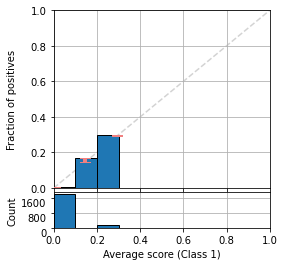

In [53]:
fig = pycalib.visualisations.plot_reliability_diagram(y_test.values,
                                                [scores_lr_beta, ],
                                                legend=None,
                                                show_histogram=True,
                                                bins=10,
                                                class_names=["0","1"],
                                                fig=None,
                                                show_counts=False,
                                                errorbar_interval=None,
                                                interval_method='beta',
                                                fmt='s-',
                                                show_correction=False,
                                                show_gaps=True,
                                                sample_proportion=0,
                                                hist_per_class=False,
                                                color_list=None,
                                                show_bars=True,
                                                invert_histogram=False,
                                                color_gaps='lightcoral',
                                                confidence=False)

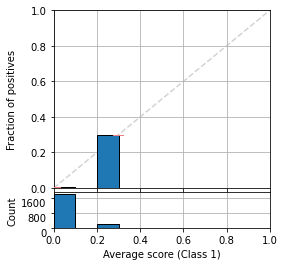

In [54]:
fig = pycalib.visualisations.plot_reliability_diagram(y_test.values,
                                                [scores_lr_beta_cv, ],
                                                legend=None,
                                                show_histogram=True,
                                                bins=10,
                                                class_names=["0","1"],
                                                fig=None,
                                                show_counts=False,
                                                errorbar_interval=None,
                                                interval_method='beta',
                                                fmt='s-',
                                                show_correction=False,
                                                show_gaps=True,
                                                sample_proportion=0,
                                                hist_per_class=False,
                                                color_list=None,
                                                show_bars=True,
                                                invert_histogram=False,
                                                color_gaps='lightcoral',
                                                confidence=False)

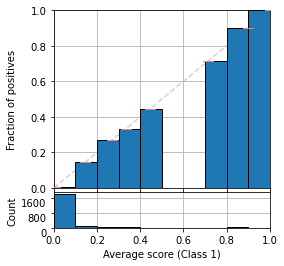

In [55]:
fig = pycalib.visualisations.plot_reliability_diagram(y_test.values,
                                                [scores_lr_iso, ],
                                                legend=None,
                                                show_histogram=True,
                                                bins=10,
                                                class_names=["0","1"],
                                                fig=None,
                                                show_counts=False,
                                                errorbar_interval=None,
                                                interval_method='beta',
                                                fmt='s-',
                                                show_correction=False,
                                                show_gaps=True,
                                                sample_proportion=0,
                                                hist_per_class=False,
                                                color_list=None,
                                                show_bars=True,
                                                invert_histogram=False,
                                                color_gaps='lightcoral',
                                                confidence=False)

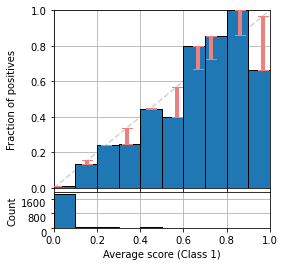

In [56]:
fig = pycalib.visualisations.plot_reliability_diagram(y_test.values,
                                                [scores_lr_iso_cv, ],
                                                legend=None,
                                                show_histogram=True,
                                                bins=10,
                                                class_names=["0","1"],
                                                fig=None,
                                                show_counts=False,
                                                errorbar_interval=None,
                                                interval_method='beta',
                                                fmt='s-',
                                                show_correction=False,
                                                show_gaps=True,
                                                sample_proportion=0,
                                                hist_per_class=False,
                                                color_list=None,
                                                show_bars=True,
                                                invert_histogram=False,
                                                color_gaps='lightcoral',
                                                confidence=False)

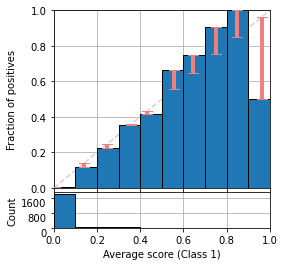

In [57]:
fig = pycalib.visualisations.plot_reliability_diagram(y_test.values,
                                                [scores_lr_sigm, ],
                                                legend=None,
                                                show_histogram=True,
                                                bins=10,
                                                class_names=["0","1"],
                                                fig=None,
                                                show_counts=False,
                                                errorbar_interval=None,
                                                interval_method='beta',
                                                fmt='s-',
                                                show_correction=False,
                                                show_gaps=True,
                                                sample_proportion=0,
                                                hist_per_class=False,
                                                color_list=None,
                                                show_bars=True,
                                                invert_histogram=False,
                                                color_gaps='lightcoral',
                                                confidence=False)

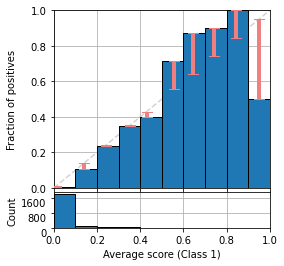

In [58]:
fig = pycalib.visualisations.plot_reliability_diagram(y_test.values,
                                                [scores_lr_sigm_cv, ],
                                                legend=None,
                                                show_histogram=True,
                                                bins=10,
                                                class_names=["0","1"],
                                                fig=None,
                                                show_counts=False,
                                                errorbar_interval=None,
                                                interval_method='beta',
                                                fmt='s-',
                                                show_correction=False,
                                                show_gaps=True,
                                                sample_proportion=0,
                                                hist_per_class=False,
                                                color_list=None,
                                                show_bars=True,
                                                invert_histogram=False,
                                                color_gaps='lightcoral',
                                                confidence=False)

## 2. SVM

In [59]:
# sigmoid
cal_svm_sigm = CalibratedClassifierCV(model2, cv="prefit", method='sigmoid')
cal_svm_sigm.fit(X_test, y_test)
scores_svm_sigm = cal_svm_sigm.predict_proba(X_test)

# Cross-validated Calibration
cal_svm_sigm_cv = CalibratedClassifierCV(model2, method='sigmoid')
cal_svm_sigm_cv.fit(X_train, y_train)
scores_svm_sigm_cv = cal_svm_sigm_cv.predict_proba(X_test)

# isotonic
cal_svm_iso = CalibratedClassifierCV(model2, cv="prefit", method='isotonic')
cal_svm_iso.fit(X_test, y_test)
scores_svm_iso = cal_svm_iso.predict_proba(X_test)

# Cross-validated Calibration
cal_svm_iso_cv = CalibratedClassifierCV(model2, method='isotonic')
cal_svm_iso_cv.fit(X_train, y_train)
scores_svm_iso_cv = cal_svm_iso_cv.predict_proba(X_test)

# beta
cal_svm_beta = CalibratedClassifierCV(model2, method='beta')
cal_svm_beta.fit(X_train, y_train)
scores_svm_beta = cal_svm_beta.predict_proba(X_test)

# Cross-validated Calibration
cal_svm_beta_cv = CalibratedClassifierCV(model2, cv="prefit", method='beta')
cal_svm_beta_cv.fit(X_test, y_test)
scores_svm_beta_cv = cal_svm_beta_cv.predict_proba(X_test)

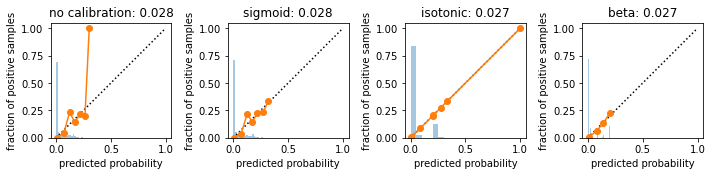

In [60]:
fig, axes = plt.subplots(1, 4, figsize=(10, 4))

for name, s, ax in zip(['no calibration', 'sigmoid', 'isotonic', 'beta'],
                       [scores_svm[:, 1], scores_svm_sigm[:, 1], scores_svm_iso[:, 1], scores_svm_beta[:, 1]], axes):
    plot_calibration_curve(y_test, s, n_bins=20, ax=ax)
    ax.set_title("{}: {:.3f}".format(name, brier_score_loss(y_test, s)))
plt.tight_layout()

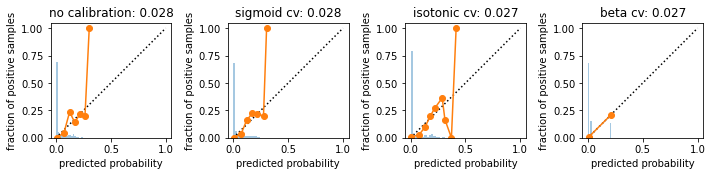

In [61]:
fig, axes = plt.subplots(1, 4, figsize=(10, 4))

for name, s, ax in zip(['no calibration', 'sigmoid cv', 'isotonic cv', 'beta cv'],
                       [scores_svm[:, 1], scores_svm_sigm_cv[:, 1], scores_svm_iso_cv[:, 1], scores_svm_beta_cv[:, 1]], axes):
    plot_calibration_curve(y_test, s, n_bins=20, ax=ax)
    ax.set_title("{}: {:.3f}".format(name, brier_score_loss(y_test, s)))
plt.tight_layout()

In [62]:
pECE(y_test, scores_svm_sigm[:,1])

0.6087

In [63]:
pECE(y_test, scores_svm_sigm_cv[:,1])

0.09284999999999999

In [64]:
pECE(y_test, scores_svm_iso[:,1])

0.9998

In [65]:
pECE(y_test, scores_svm_iso_cv[:,1])

0.84865

In [66]:
pECE(y_test, scores_svm_beta[:,1])

0.5392

In [67]:
pECE(y_test, scores_svm_beta_cv[:,1])

0.99625

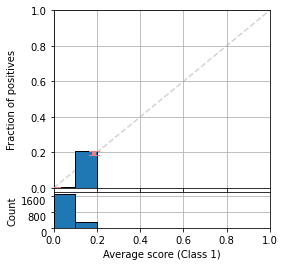

In [68]:
fig = pycalib.visualisations.plot_reliability_diagram(y_test.values,
                                                [scores_svm_beta, ],
                                                legend=None,
                                                show_histogram=True,
                                                bins=10,
                                                class_names=["0","1"],
                                                fig=None,
                                                show_counts=False,
                                                errorbar_interval=None,
                                                interval_method='beta',
                                                fmt='s-',
                                                show_correction=False,
                                                show_gaps=True,
                                                sample_proportion=0,
                                                hist_per_class=False,
                                                color_list=None,
                                                show_bars=True,
                                                invert_histogram=False,
                                                color_gaps='lightcoral',
                                                confidence=False)

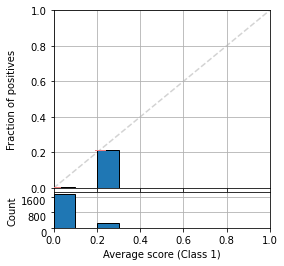

In [69]:
fig = pycalib.visualisations.plot_reliability_diagram(y_test.values,
                                                [scores_svm_beta_cv, ],
                                                legend=None,
                                                show_histogram=True,
                                                bins=10,
                                                class_names=["0","1"],
                                                fig=None,
                                                show_counts=False,
                                                errorbar_interval=None,
                                                interval_method='beta',
                                                fmt='s-',
                                                show_correction=False,
                                                show_gaps=True,
                                                sample_proportion=0,
                                                hist_per_class=False,
                                                color_list=None,
                                                show_bars=True,
                                                invert_histogram=False,
                                                color_gaps='lightcoral',
                                                confidence=False)

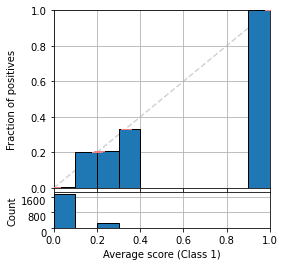

In [70]:
fig = pycalib.visualisations.plot_reliability_diagram(y_test.values,
                                                [scores_svm_iso, ],
                                                legend=None,
                                                show_histogram=True,
                                                bins=10,
                                                class_names=["0","1"],
                                                fig=None,
                                                show_counts=False,
                                                errorbar_interval=None,
                                                interval_method='beta',
                                                fmt='s-',
                                                show_correction=False,
                                                show_gaps=True,
                                                sample_proportion=0,
                                                hist_per_class=False,
                                                color_list=None,
                                                show_bars=True,
                                                invert_histogram=False,
                                                color_gaps='lightcoral',
                                                confidence=False)

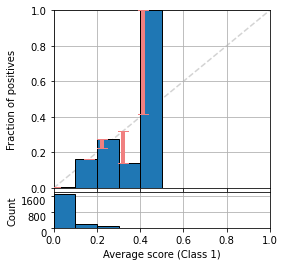

In [71]:
fig = pycalib.visualisations.plot_reliability_diagram(y_test.values,
                                                [scores_svm_iso_cv, ],
                                                legend=None,
                                                show_histogram=True,
                                                bins=10,
                                                class_names=["0","1"],
                                                fig=None,
                                                show_counts=False,
                                                errorbar_interval=None,
                                                interval_method='beta',
                                                fmt='s-',
                                                show_correction=False,
                                                show_gaps=True,
                                                sample_proportion=0,
                                                hist_per_class=False,
                                                color_list=None,
                                                show_bars=True,
                                                invert_histogram=False,
                                                color_gaps='lightcoral',
                                                confidence=False)

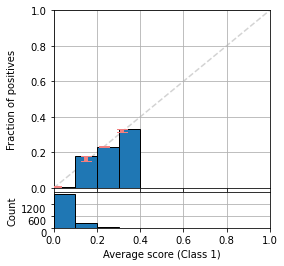

In [72]:
fig = pycalib.visualisations.plot_reliability_diagram(y_test.values,
                                                [scores_svm_sigm, ],
                                                legend=None,
                                                show_histogram=True,
                                                bins=10,
                                                class_names=["0","1"],
                                                fig=None,
                                                show_counts=False,
                                                errorbar_interval=None,
                                                interval_method='beta',
                                                fmt='s-',
                                                show_correction=False,
                                                show_gaps=True,
                                                sample_proportion=0,
                                                hist_per_class=False,
                                                color_list=None,
                                                show_bars=True,
                                                invert_histogram=False,
                                                color_gaps='lightcoral',
                                                confidence=False)

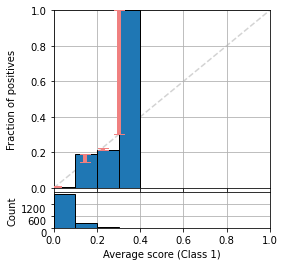

In [73]:
fig = pycalib.visualisations.plot_reliability_diagram(y_test.values,
                                                [scores_svm_sigm_cv, ],
                                                legend=None,
                                                show_histogram=True,
                                                bins=10,
                                                class_names=["0","1"],
                                                fig=None,
                                                show_counts=False,
                                                errorbar_interval=None,
                                                interval_method='beta',
                                                fmt='s-',
                                                show_correction=False,
                                                show_gaps=True,
                                                sample_proportion=0,
                                                hist_per_class=False,
                                                color_list=None,
                                                show_bars=True,
                                                invert_histogram=False,
                                                color_gaps='lightcoral',
                                                confidence=False)